# This method uses U-Net model for creating masks from benign and malignant cancer ultrasound photos and segmentating them.

### We start off by importing essential libraries etc.

In [1]:
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras

### Then, we want to create an image loader function for easier data load.

In [2]:
## defining a frame for image and mask storage

framObjTrain = {'img' : [],
           'mask' : []
          }

## defining data Loader function
def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 256):
    imgNames = os.listdir(imgPath)
    
    names = []
    maskNames = []
    unames = []
    
    for i in range(len(imgNames)):
        unames.append(imgNames[i].split(')')[0])

    unames = list(set(unames))

    for i in range(len(unames)):
        names.append(unames[i]+').png')
        maskNames.append(unames[i]+')_mask.png')
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    for i in range (len(names)):
        img = plt.imread(imgAddr + names[i])
        mask = plt.imread(maskAddr + maskNames[i])
        
        img = cv2.resize(img, (shape, shape)) 
        mask = cv2.resize(mask, (shape, shape))
        
        frameObj['img'].append(img)
        frameObj['mask'].append(mask)
        
    return frameObj

### Now, we have to load benign and malignant cancer images from the dataset.

In [3]:
# loading benign samples
framObjTrain = LoadData( framObjTrain, imgPath = 'Dataset_BUSI_with_GT/benign'
                        , maskPath = 'Dataset_BUSI_with_GT/benign'
                         , shape = 256)

In [4]:
# loading malignant samples
framObjTrain = LoadData( framObjTrain, imgPath = 'Dataset_BUSI_with_GT/malignant'
                        , maskPath = 'Dataset_BUSI_with_GT/malignant'
                         , shape = 256)

### Let's display one image and it's mask from the loaded data for a better overview.

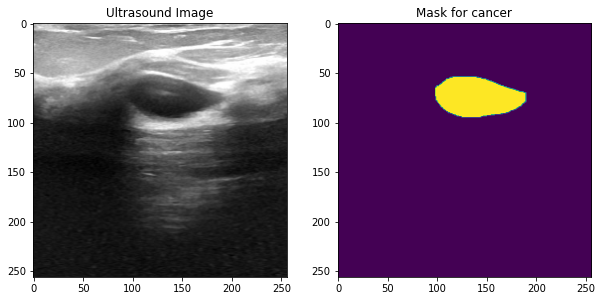

In [5]:
## displaying data loaded by our function
plt.figure(figsize = (10, 7))
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][1])
plt.title('Ultrasound Image')
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][1])
plt.title('Mask for cancer')
plt.show()

## Let's define our model now.

Our model is going to be a U-Net model, a great model for medical purposes as it yields a great accuracy at showing abnormalities in medical photos.

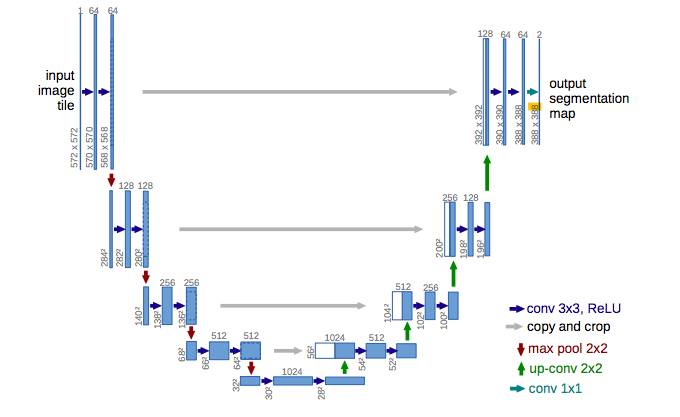

As you can see from the picture above, the model consists in half of double conv 3x3 layers with ReLu actiation swapped with max pool 2x2 and in half of conv 3x3 with ReLu actiation and up-conv 2x2.

This is why we need a custom function called `Conv2DBlock` which will perform two Conv2D operations from keras.

In [6]:
# this block essentially performs 2 convolution

def Conv2DBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x


# Now defining Unet 
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2DBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2DBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2DBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2DBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2DBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2DBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2DBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2DBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2DBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

#### Here I want to instantiate the model before starting learning.

In [7]:
inputs = tf.keras.layers.Input((256, 256, 3))
model = GiveMeUnet(inputs, droupouts = 0.07)
model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

### Training model for 50 epochs (~ 3h on my machine).

In [8]:
retVal = model.fit(np.array(framObjTrain['img']), np.array(framObjTrain['mask']), epochs = 50, verbose = 1)

Epoch 1/50
21/21 [==============================] - 167s 8s/step - loss: 0.6539 - accuracy: 0.6740
Epoch 2/50
21/21 [==============================] - 161s 8s/step - loss: 0.4461 - accuracy: 0.9111
Epoch 3/50
21/21 [==============================] - 161s 8s/step - loss: 0.4076 - accuracy: 0.9101
Epoch 4/50
21/21 [==============================] - 162s 8s/step - loss: 0.3755 - accuracy: 0.9118
Epoch 5/50
21/21 [==============================] - 160s 8s/step - loss: 0.3537 - accuracy: 0.9116
Epoch 6/50
21/21 [==============================] - 162s 8s/step - loss: 0.3334 - accuracy: 0.9134
Epoch 7/50
21/21 [==============================] - 159s 8s/step - loss: 0.3157 - accuracy: 0.9145
Epoch 8/50
21/21 [==============================] - 158s 7s/step - loss: 0.2860 - accuracy: 0.9228
Epoch 9/50
21/21 [==============================] - 158s 8s/step - loss: 0.2640 - accuracy: 0.9267
Epoch 10/50
21/21 [==============================] - 158s 8s/step - loss: 0.2403 - accuracy: 0.9311
Epoch 11/

Let's see how the model performed by looking up training loss and training accuracy.

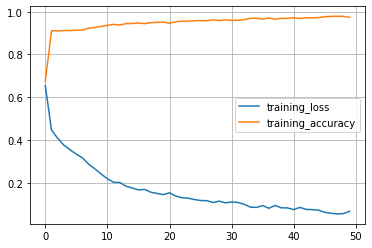

In [9]:
plt.plot(retVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

Finally, let's see the results.

In [10]:
def predict16 (valMap, model, shape = 256):
    ## getting and proccessing val data
    img = valMap['img'][0:16]
    mask = valMap['mask'][0:16]
    #mask = mask[0:16]
    
    imgProc = img [0:16]
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
  

    return predictions, imgProc, mask


def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(9,9))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title(' image')
    
    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted mask')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('Actual mask')

1/1 [==============================] - 1s 715ms/step


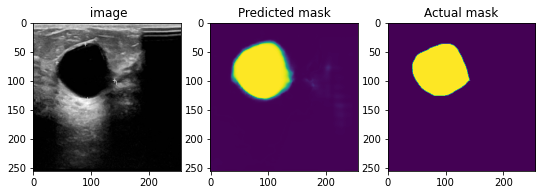

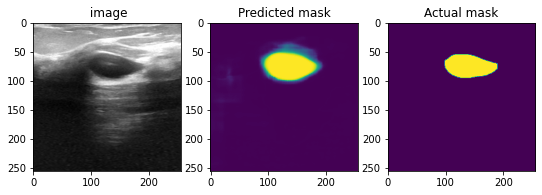

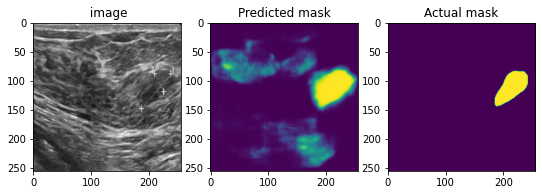

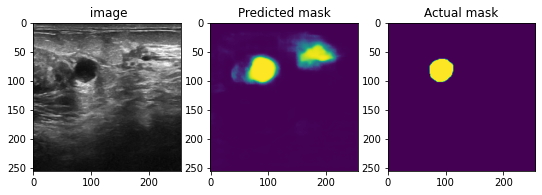

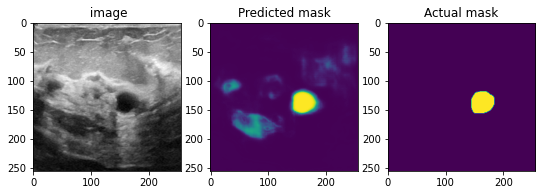

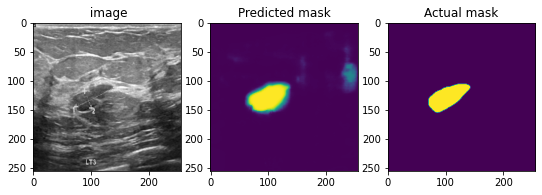

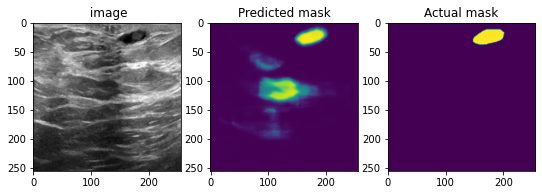

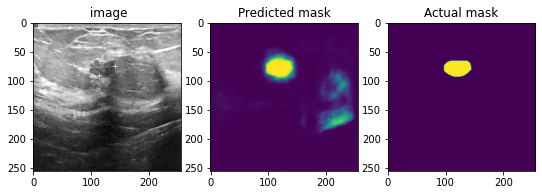

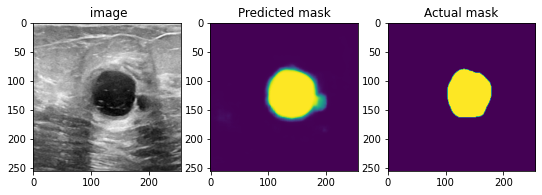

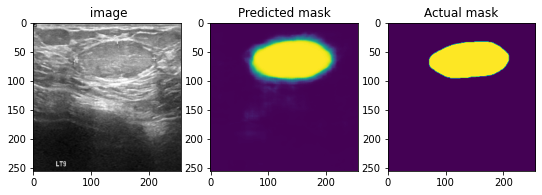

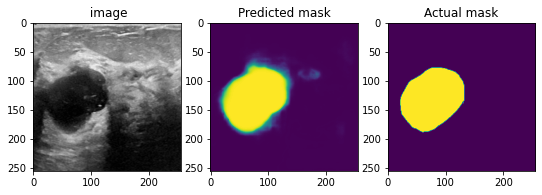

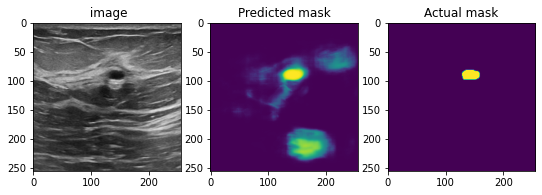

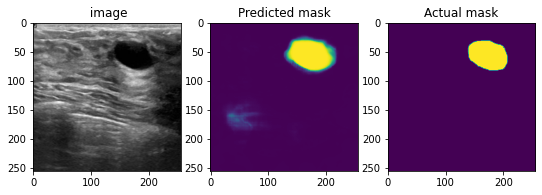

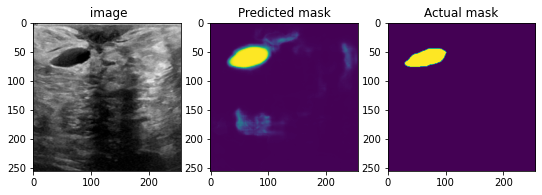

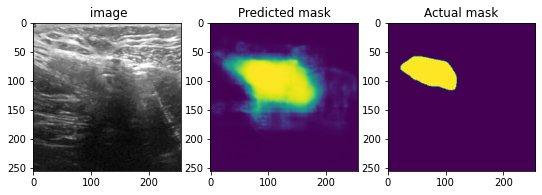

In [14]:
sixteenPrediction, actuals, masks = predict16(framObjTrain, model)
for i in range(0, 15):
    Plotter(actuals[i], sixteenPrediction[i][:,:,0], masks[i])